In [30]:
using LowLevelFEM
import LowLevelFEM as FEM

gmsh.initialize()

In [31]:
using SparseArrays, LinearAlgebra

In [32]:
gmsh.open("body2.geo")

Info    : Reading 'body2.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000672262s, CPU 0.000648s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 20%] Meshing surface 2 (Transfinite)
Info    : [ 40%] Meshing surface 3 (Transfinite)
Info    : [ 60%] Meshing surface 4 (Transfinite)
Info    : [ 70%] Meshing surface 5 (Transfinite)
Info    : [ 90%] Meshing surface 6 (Transfinite)
Info    : Done meshing 2D (Wall 0.000252103s, CPU 0.000252s)
Info    : Meshing 3D

In [33]:
mat = FEM.material("body", μ=100, ν=0.3)
hooke = FEM.Problem([mat], type=:Solid)
stvenkir = FEM.Problem([mat], type=:StVenantKirchhoff)
neohooke = FEM.Problem([mat], type=:NeoHookeCompressible)

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)
Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 61)


LowLevelFEM.Problem("body2", :NeoHookeCompressible, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", 200000.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 275)

In [34]:
supp = FEM.displacementConstraint("left", ux=0, uy=0, uz=0)
suppL = FEM.displacementConstraint("left", ux=0)
suppB = FEM.displacementConstraint("bottom", uy=0)
suppF = FEM.displacementConstraint("front", uz=0)
traction = FEM.load("right", fx=2000)
bodyforce = FEM.load("body", fx=1)

problem = hooke
q = FEM.solveDisplacement(problem, [traction], [suppL, suppB, suppF])
S = FEM.solveStress(problem, q)

LowLevelFEM.TensorField([[2000.0000000000312; 5.004010026856174e-14; … ; -1.3344026738283132e-12; 1.0231815394945443e-12;;], [2000.000000000029; 1.367762740674021e-12; … ; 1.3344026738283131e-13; -2.3305801732931286e-12;;], [2000.0000000000282; -4.595349207996253e-12; … ; 2.6688053476566263e-13; 5.6843418860808015e-12;;], [2000.0000000000193; 1.4678429412111444e-12; … ; -2.2684845455081324e-12; 5.6274984672199935e-12;;], [2000.0000000000286; -4.87890977618477e-12; … ; 6.672013369141566e-13; -4.092726157978177e-12;;], [2000.0000000000234; -6.755413536255836e-13; … ; -2.6688053476566263e-13; 2.1032064978498966e-12;;], [2000.0000000000432; -9.365838766932472e-12; … ; 2.6688053476566263e-13; -5.4569682106375694e-12;;], [2000.000000000024; 1.7413954893459486e-11; … ; 4.003208021484939e-13; 6.87805368215777e-12;;], [2000.000000000009; -1.0950441942103595e-11; … ; -6.672013369141566e-13; 3.581135388230905e-12;;], [1999.999999999994; 5.946431915247421e-12; … ; -9.340818716798193e-13; 4.0927261

In [35]:
u1 = FEM.showDoFResults(problem, q, :uvec)
S1 = FEM.showElementResults(problem, S, :s)

Info    : Running Plugin(Smooth)...
Info    : Done running Plugin(Smooth)


1

In [36]:
problem = stvenkir
problem = neohooke

LowLevelFEM.Problem("body2", :NeoHookeCompressible, 3, 3, LowLevelFEM.Material[LowLevelFEM.Material("body", 200000.0, 0.3, 7.85e-9, 45.0, 4.2e8, 1.2e-5, 150.0, 100.0, 216.66666666666666)], 1.0, 275)

In [37]:
followerLoad = false
loadSteps = 10
firstStep = 0.1
maxIteration = 10
saveSteps = true
saveIterations = false
plotConvergence = true
ε = 1e-3

r0 = FEM.nodePositionVector(problem)
err0 = abs(maximum(r0) - minimum(r0))
f = FEM.loadVector(problem, [traction])
r = []
r1 = []
push!(r, r0)
e = []

for j in range(1, loadSteps)
    fact = j / loadSteps
    err = 1
    i = 0
    while err > ε && i < maxIteration
        i += 1

        Kl = FEM.stiffnessMatrixLinear(problem, r0)
        Knl = FEM.stiffnessMatrixNonLinear(problem, r0)
        if followerLoad == true
            f = FEM.followerLoadVector(problem, r0, [traction])
        end
        fnl = FEM.loadVectorNonLinear(problem, r0)
        K1, f1 = FEM.applyBoundaryConditions(problem, Kl + Knl, fact * f - fnl, [suppL, suppB, suppF])
        q = FEM.solveDisplacement(K1, f1)
        r0 += q
        if saveIterations == true
            push!(r, r0)
        end
        err = maximum(abs.(q)) / err0
        if plotConvergence == true
            append!(e, err)
        end
    end
    if saveSteps == true
        push!(r, r0)
    end
end
if saveIterations == true || saveSteps == true
    n = length(r)
    r1 = zeros(length(r0), n)
    for i in 1:n
        r1[:, i] = r[i]
    end
else
    r1 = zeros(length(r0), 1)
    r1 = r0
end

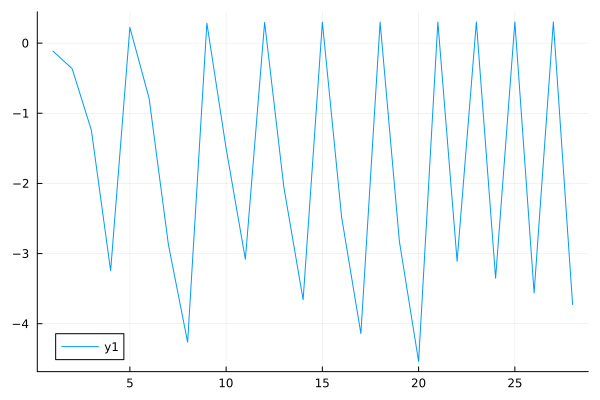

In [38]:
using Plots
plot(log10.(e))

In [39]:
u1 = similar(r1)
r0 = FEM.nodePositionVector(problem)
for i in 1:size(r1, 2)
    u1[:, i] = r1[:, i] - r0
end

u2 = FEM.showDoFResults(problem, u1, :uvec, t=1:size(u1, 2), visible=true)

2

In [40]:
#FEM.plotOnPath(problem, "horizontal", u2)
#FEM.plotOnPath(problem, "vertical", u2)

In [41]:
r = FEM.nodePositionVector(problem)
ux(x, y, z) = 0.4x
uy(x, y, z) = 0.5y
uz(x, y, z) = 0.6z
q0 = FEM.field("body", fx=ux, fy=uy, fz=uz)
q = FEM.vectorField(problem, [q0])
F = FEM.deformationGradient(problem, q)

LowLevelFEM.TensorField([[0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;]  …  [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000000000001;;], [0.3999999999999999; 0.0; … ; 0.0; 0.6000000

In [42]:
reshape(F.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [43]:
E = (F' * F - FEM.unitTensor(F)) / 2

reshape(E.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -0.42   0.0     0.0
  0.0   -0.375   0.0
  0.0    0.0    -0.32

In [44]:
e = (FEM.unitTensor(F) - inv(F * F')) / 2

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [45]:
e = inv(F') * E * inv(F)

reshape(e.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -2.625   0.0   0.0
  0.0    -1.5   0.0
  0.0     0.0  -0.888889

In [46]:
U = sqrt(F' * F)

reshape(U.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 0.4  0.0  0.0
 0.0  0.5  0.0
 0.0  0.0  0.6

In [47]:
Ex = 10
νxy = 0.3
λ = Ex * νxy / ((1 + νxy) * (1 - 2νxy))
μ = Ex / (2 * (1 + νxy))
I3 = FEM.unitTensor(F)
iC = inv(F' * F)
J1 = det(F)
SII = μ * (I3 - iC) + λ * log(J1) / J1 * I3

reshape(SII.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -122.128     0.0       0.0
    0.0    -113.474     0.0
    0.0       0.0    -108.773

In [48]:
function probe(A, x, y, z)
    elementTag, elementType, nodeTags, u, v, w = gmsh.model.mesh.getElementByCoordinates(x, y, z, 3, false)
    elementName, dim, order, numNodes::Int64, localNodeCoord, numPrimaryNodes = gmsh.model.mesh.getElementProperties(elementType)
    comp, fun, ori = gmsh.model.mesh.getBasisFunctions(elementType, [u, v, w], "Lagrange")
    SS = [0.0, 0, 0, 0, 0, 0, 0, 0, 0]
    if isa(A, FEM.TensorField)
        ind = findfirst(i -> i == elementTag, SII.numElem)
        for i in range(1, 9)
            SS[i] = fun' * SII.A[ind][i:9:9numNodes, 1]
        end
    elseif isa(A, Matrix)
        for i in range(1, 9)
            SS[i] = fun' * A[9nodeTags.-(9-i), 1]
        end
    end
    return reshape(SS, 3, 3)
end

probe (generic function with 1 method)

In [49]:
SII2 = FEM.elementsToNodes(problem, SII)

2475×1 Matrix{Float64}:
 -122.12805462500447
    0.0
    4.74454284027845e-14
    0.0
 -113.47420847115829
    0.0
    4.74454284027845e-14
    0.0
 -108.7733537703036
 -122.12805462500434
    ⋮
 -122.12805462500438
   -8.540177112501207e-15
    4.688942728868993e-15
   -8.540177112501207e-15
 -113.47420847115822
   -7.116814260417605e-16
    4.688942728868993e-15
   -7.116814260417605e-16
 -108.77335377030352

In [50]:
probe(SII2, 0, 0, 0)

3×3 Matrix{Float64}:
 -122.128           4.49134e-44    -9.48909e-15
    4.49134e-44  -113.474           5.0568e-29
   -9.48909e-15     5.0568e-29   -108.773

In [51]:
field = FEM.field("body", f=2)
sc = FEM.ScalarField(problem, [field])

LowLevelFEM.ScalarField([[2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]  …  [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;], [2.0; 2.0; … ; 2.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :scalarInElements)

In [52]:
I3 = FEM.unitTensor(F)
J = det(F)

LowLevelFEM.ScalarField([[0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;]  …  [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;], [0.12; 0.11999999999999994; … ; 0.12; 0.12;;]], Matrix{Float64}(undef, 0, 0), [

In [53]:
sc * I3

LowLevelFEM.TensorField([[2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]  …  [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;], [2.0; 0.0; … ; 0.0; 2.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :e)

In [54]:
I3 - I3

LowLevelFEM.TensorField([[0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]  …  [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;], [0.0; 0.0; … ; 0.0; 0.0;;]], Matrix{Float64}(undef, 0, 0), [273, 274, 275, 276, 277, 278, 279, 280, 281, 282  …  423, 424, 425, 426, 427, 428, 429, 430, 431, 432], 1, :e)

In [55]:
σ = F * SII * F' / det(F)

reshape(σ.A[1][1:9], 3, 3)

3×3 Matrix{Float64}:
 -162.837     0.0       0.0
    0.0    -236.405     0.0
    0.0       0.0    -326.32

In [56]:
J = 0.5 * 0.5 * 0.5
μ / J * (J^(2 / 3) - 1) + λ / J * log(J)

-119.05114807753088

In [57]:
FEM.openPostProcessor()

-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 19700101
Build host    : amdci7.julia.csail.mit.edu
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Untangle Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.7.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


XRequest.18: BadValue 0x0


In [58]:
gmsh.finalize()